In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic_2d
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import RegularPolygon, Arrow, ArrowStyle,FancyArrowPatch, Circle,FancyArrow
from mplsoccer.pitch import Pitch, VerticalPitch
from matplotlib.colors import Normalize
from matplotlib import cm
from highlight_text import fig_text, ax_text


import warnings
warnings.filterwarnings("ignore")

## 1. Load data

- preprocessed event data (with open-play xT scores)

In [2]:
path1 = './data/Man_City_1_1_Chelsea_17022024_opta_events_processed.csv'
path2 = './data/1729486_Man_City_1_1_Chelsea.json'

In [3]:
events_df = pd.read_csv(path1)

print(events_df.shape)

events_df.head()

(1716, 260)


,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,period,...,penaltyShootoutConcededGK,throwIn,subOn,subOff,defensiveThird,midThird,finalThird,pos,teamName,xT_added
0,2.647549e+09,2,0,0.0,15,a,0.0,0.0,0,FirstHalf,...,False,False,False,False,False,False,False,False,Chelsea,0.000000
1,2.647549e+09,2,0,0.0,167,h,0.0,0.0,0,FirstHalf,...,False,False,False,False,False,False,False,False,Man City,0.000000
2,2.647549e+09,3,0,0.0,15,a,50.1,50.0,0,FirstHalf,...,False,False,False,False,True,False,False,True,Chelsea,0.000000
3,2.647549e+09,4,0,2.0,15,a,30.8,54.2,0,FirstHalf,...,False,False,False,False,False,False,True,True,Chelsea,0.017476
4,2.647549e+09,5,0,5.0,15,a,67.1,19.8,0,FirstHalf,...,False,False,False,False,False,True,False,True,Chelsea,0.000000


In [4]:
events_df[events_df['type'] == 'Pass'].groupby(['teamName']).agg({'id':'nunique'})

,id
teamName,
Chelsea,331
Man City,784


- row json data

In [5]:
with open(path2, 'r') as f:
    match_data = json.load(f)

In [6]:
match_data.keys()

dict_keys(['attendance', 'away', 'commonEvents', 'competitionStage', 'competitionType', 'elapsed', 'etScore', 'events', 'expandedMaxMinute', 'expandedMinutes', 'formationIdNameMappings', 'ftScore', 'home', 'htScore', 'league', 'matchCentreEventTypeJson', 'matchId', 'maxMinute', 'maxPeriod', 'minuteExpanded', 'periodCode', 'periodEndMinutes', 'periodMinuteLimits', 'pkScore', 'playerIdNameDictionary', 'referee', 'region', 'score', 'season', 'startDate', 'startTime', 'statusCode', 'timeStamp', 'timeoutInSeconds', 'venueName', 'weatherCode'])

In [7]:
# match_data['events'][0]

In [8]:
# match_data['away'].keys()

In [9]:
# match_data['away']['stats'].keys()

## 2. Preprocessing

### 2.1. Creates passes dataframes

In [10]:
res_dict = {}

teamIds = events_df['teamId'].unique()

for teamId in teamIds:
    
    mask = events_df['teamId'] == teamId
    df_ = events_df[mask]
    
    teamName = df_['teamName'].unique()[0]
        
    venue = 'home' if df_[df_['teamId'] == teamId]['h_a'].unique()[0] == 'h' else 'away'

    mask1 = df_['cardType'].apply(lambda x: x in ["SecondYellow", "Red"])
    first_red_card_minute = df_[mask1].minute.min()

    mask2 = events_df['type'] == 'SubstitutionOn'
    first_sub_min = events_df[mask2].minute.min()

    max_minute = df_.minute.max()

    num_minutes = min(first_sub_min, first_red_card_minute, max_minute)
      
    passes_df = df_.reset_index().drop('index', axis=1)
    passes_df['playerId'] = passes_df['playerId'].astype('Int64')
    passes_df = passes_df[passes_df['playerId'].notnull()]
    passes_df['passRecipientName'] = passes_df['playerName'].shift(-1)
    passes_df = passes_df[passes_df['passRecipientName'].notnull()]
    
    #DF with all passes
    mask1 = passes_df['type'].apply(lambda x: x in ['Pass'])
    passes_df_all = passes_df[mask1]
    
    #DF with all passes before num_minutes (additional filter on first 11 players)
    mask2 = passes_df_all['minute'] < num_minutes
    players = passes_df_all[passes_df_all['minute'] < num_minutes]['playerName'].unique()
    mask3 = passes_df_all['playerName'].apply(lambda x: x in players)
    passes_df_short = passes_df_all[mask2 & mask3]
    
    
    #DF with successed / completed passes
    mask2 = passes_df_all['playerName'] != passes_df_all['passRecipientName']
    mask3 = passes_df_all['outcomeType'] == 'Successful'
    passes_df_suc = passes_df_all[mask2&mask3]
    

    #DF with successed passes before num_minutes (additional filter on first 11 players)
    mask2 = passes_df_suc['minute'] < num_minutes
    players = passes_df_suc[passes_df_suc['minute'] < num_minutes]['playerName'].unique()
    mask3 = passes_df_suc['playerName'].apply(lambda x: x in players) & \
            passes_df_suc['passRecipientName'].apply(lambda x: x in players)
    passes_df_suc_short = passes_df_suc[mask2 & mask3]
    
    print('team: ',teamName)
    print('passes: ', passes_df_all.shape[0])
    print('suc passes: ', passes_df_suc.shape[0])
    print('last minute: min(first red / substitution / end game) = ', num_minutes)
    
    print('suc passes befor last minute: ', passes_df_short.shape[0])
    print('\n')
    
    res_dict[teamId] = {}
    
    res_dict[teamId]['passes_df_all'] = passes_df_all
    res_dict[teamId]['passes_df_short'] = passes_df_short
    res_dict[teamId]['passes_df_suc'] = passes_df_suc
    res_dict[teamId]['passes_df_suc_short'] = passes_df_suc_short
    res_dict[teamId]['minutes'] = num_minutes

    
    


team:  Chelsea
passes:  331
suc passes:  264
last minute: min(first red / substitution / end game) =  63
suc passes befor last minute:  257


team:  Man City
passes:  783
suc passes:  688
last minute: min(first red / substitution / end game) =  63
suc passes befor last minute:  510




In [11]:
teamIds

array([ 15, 167])

#### got 4 DFs:
 - res_dict[teamId]['passes_df_all'] - all passes
 - res_dict[teamId]['passes_df_suc'] - only completed 
 - res_dict[teamId]['passes_df_short'] - before final minute 
 - res_dict[teamId]['passes_df_suc_short'] - only completed before final minute 

### 2.2. Adding statistics

In [12]:
var = 'playerName'
var2 = 'passRecipientName'

for teamId in teamIds:

    passes_df_all = res_dict[teamId]['passes_df_all']
    passes_df_suc = res_dict[teamId]['passes_df_suc']
    passes_df_short = res_dict[teamId]['passes_df_short']
    passes_df_suc_short = res_dict[teamId]['passes_df_suc_short']
    
    player_position = passes_df_short.groupby(var).agg({'x': ['median'], 'y': ['median']})

    player_position.columns = ['x', 'y']
    player_position.index.name = 'playerName'
    player_position.index = player_position.index.astype(str)

    player_pass_count_all = passes_df_all.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes_all'})
    player_pass_count_suc = passes_df_suc.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes'})
    player_pass_count_suc_short = passes_df_suc_short.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes2'})
    player_pass_count = player_pass_count_all.join(player_pass_count_suc).join(player_pass_count_suc_short)
    
        
    passes_df_all["pair_key"] = passes_df_all.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc["pair_key"] = passes_df_suc.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc_short["pair_key"] = passes_df_suc_short.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)


    
    pair_pass_count_all = passes_df_all.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes_all'})
    pair_pass_count_suc = passes_df_suc.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes'})
    pair_pass_count_suc_short = passes_df_suc_short.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes2'})
    pair_pass_count = pair_pass_count_all.join(pair_pass_count_suc).join(pair_pass_count_suc_short)
    
    
    
    player_pass_value_suc = (passes_df_suc.groupby(var)
                                 .agg({'xT_added':'sum'})
                                 .round(3)
                                 .rename(columns={'xT_added':'pass_value'}))
    player_pass_value_suc_short = (passes_df_suc_short.groupby(var)
                                 .agg({'xT_added':'sum'})
                                 .round(3)
                                 .rename(columns={'xT_added':'pass_value2'}))
    player_pass_value = player_pass_value_suc.join(player_pass_value_suc_short)

    
    
                
    pair_pass_value_suc = (passes_df_suc.groupby(['pair_key'])
                               .agg({'xT_added':'sum'})
                               .round(3)
                               .rename(columns={'xT_added':'pass_value'}))
    pair_pass_value_suc_short = (passes_df_suc_short.groupby(['pair_key'])
                           .agg({'xT_added':'sum'})
                           .round(3)
                           .rename(columns={'xT_added':'pass_value2'}))
    pair_pass_value = pair_pass_value_suc.join(pair_pass_value_suc_short)

    
    player_position['z'] = player_position['x']
    player_position['x'] = player_position['y']
    player_position['y'] = player_position['z']
    
    res_dict[teamId]['player_position'] = player_position
    res_dict[teamId]['player_pass_count'] = player_pass_count
    res_dict[teamId]['pair_pass_count'] = pair_pass_count
    res_dict[teamId]['player_pass_value'] = player_pass_value
    res_dict[teamId]['pair_pass_value'] = pair_pass_value




In [13]:
res_dict[15].keys()

dict_keys(['passes_df_all', 'passes_df_short', 'passes_df_suc', 'passes_df_suc_short', 'minutes', 'player_position', 'player_pass_count', 'pair_pass_count', 'player_pass_value', 'pair_pass_value'])

## 3. Visualization

### 3.1. Settings

- create colormap (cmap) for nodes = additional layer with xT metric

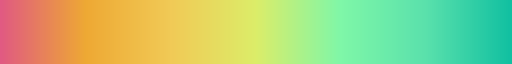

In [14]:
nodes_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#E15A82',
                                                               '#EEA934',
                                                               '#F1CA56',
                                                               '#DCED69',
                                                               '#7FF7A8',
                                                               '#5AE1AC',
                                                               '#11C0A1'
                                                               
                                                                       
                                                            ])
nodes_cmap

- colors for legend below the graph

In [15]:
node_cmap = cm.get_cmap(nodes_cmap)

norm = Normalize(vmin=0, vmax=1)
node_color1 = node_cmap(norm(0)) 
node_color2 = node_cmap(norm(0.25)) 
node_color3 = node_cmap(norm(0.5)) 
node_color4 = node_cmap(norm(0.75)) 
node_color5 = node_cmap(norm(1)) 

- function for normalization size of Nodes and Edges to align absolute number of passes for set limits

In [16]:
def change_range(value, old_range, new_range):

    new_value = ((value-old_range[0]) / (old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]
    
    if new_value >= new_range[1]:
        return new_range[1]
    elif new_value <= new_range[0]:
        return new_range[0]
    else:
        return new_value

- define limitations

In [17]:
#nodes
min_node_size = 5
max_node_size = 35

max_player_count = 88
min_player_count = 1

max_player_value = 0.36
min_player_value = 0.01

#font
font_size = 8
font_color = 'black'

#edges arrow

min_edge_width = 0.5
max_edge_width = 5

head_length = 0.3
head_width = 0.1

max_pair_count = 16
min_pair_count = 1

min_pair_value  = 0.01
max_pair_value = 0.085

min_passes = 5

### 3.2 Plotting pitches and prepare data

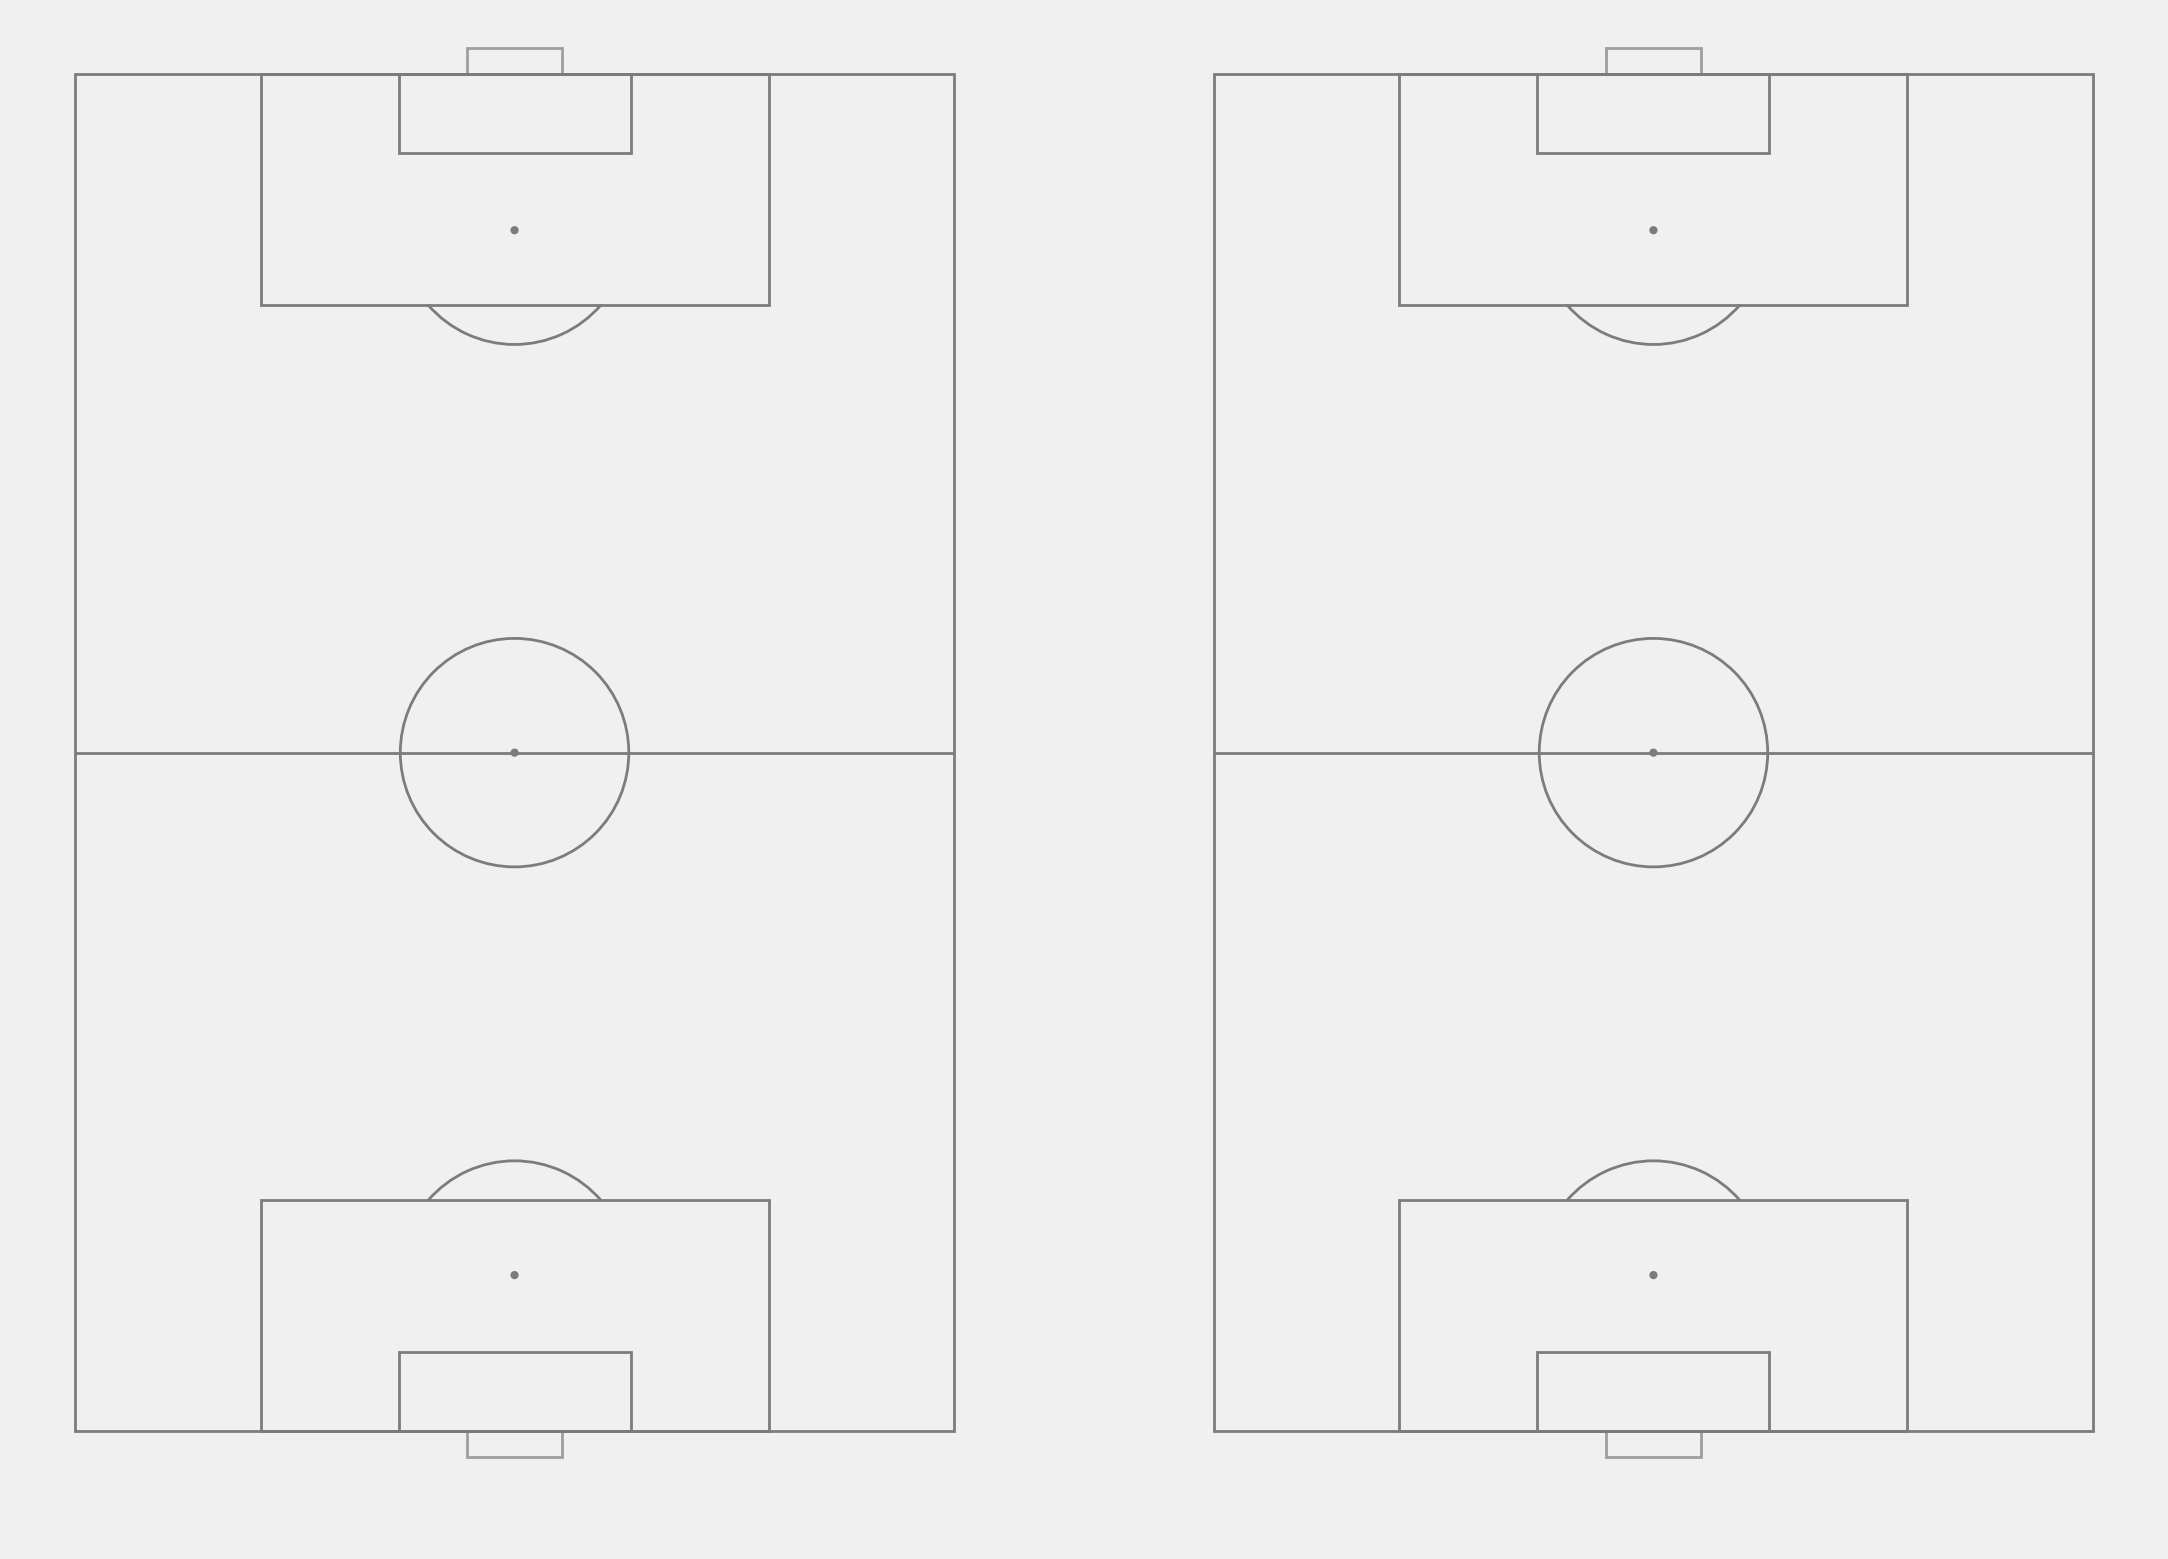

In [18]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(6,6), dpi=400)

teamId_home = events_df[events_df['h_a'] == 'h']['teamId'].unique()[0]
teamId_away = events_df[events_df['h_a'] == 'a']['teamId'].unique()[0]

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    player_pass_value = res_dict[teamid]['player_pass_value']
    pair_pass_value = res_dict[teamid]['pair_pass_value']
    minutes_ = res_dict[teamid]['minutes']

    pitch = VerticalPitch(pitch_type='opta', 
                          line_color='#7c7c7c',
                          goal_type='box',
                          linewidth=0.5,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    # Step 1: processing for plotting edges
    pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
    pair_stats = pair_stats.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]
    
    # Step 2: processing for plotting nodes
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    
    #FILTER first 11 players
    mask = events_df['minute'] < minutes_
    players_ = list(set(events_df[mask]['playerName'].dropna()))
    
    mask_ = player_stats.index.map(lambda x: x in players_)
    player_stats = player_stats.loc[mask_]
    
    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]
    
    
    

### 3.3 Plotting nodes

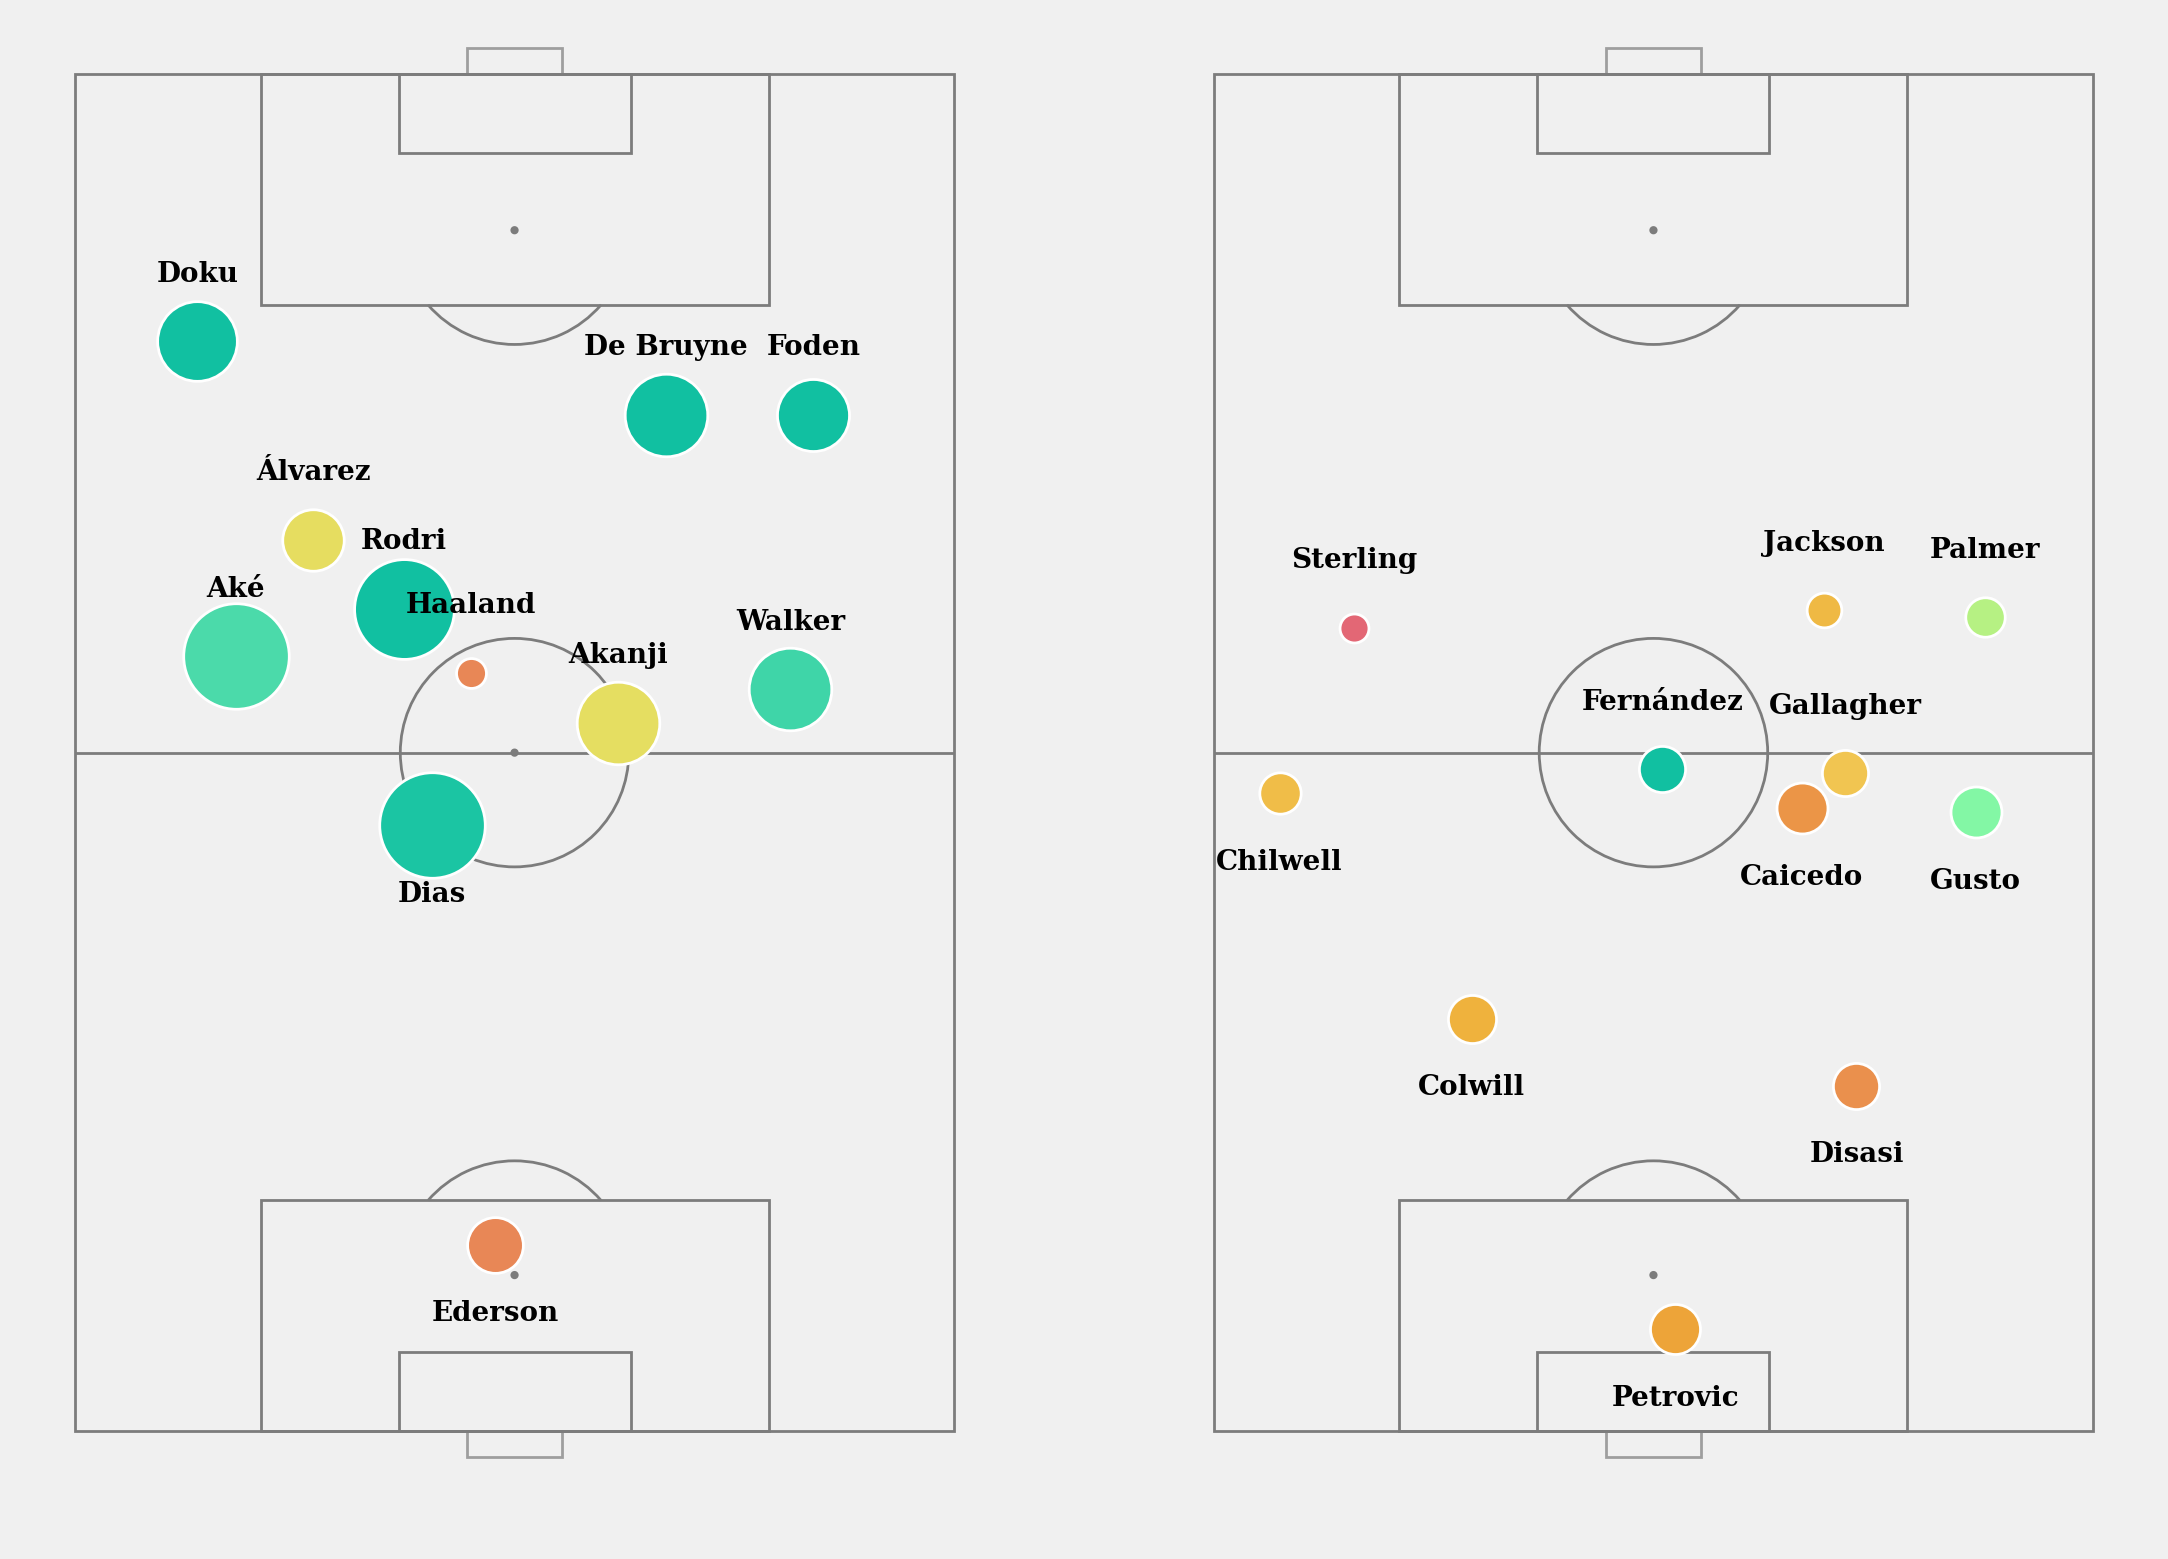

In [19]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(6,6), dpi=400)

teamId_home = events_df[events_df['h_a'] == 'h']['teamId'].unique()[0]
teamId_away = events_df[events_df['h_a'] == 'a']['teamId'].unique()[0]

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    player_pass_value = res_dict[teamid]['player_pass_value']
    pair_pass_value = res_dict[teamid]['pair_pass_value']
    minutes_ = res_dict[teamid]['minutes']

    pitch = VerticalPitch(pitch_type='opta', 
                          line_color='#7c7c7c',
                          goal_type='box',
                          linewidth=0.5,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    # Step 1: processing for plotting edges
    pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
    pair_stats = pair_stats.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]
    
    # Step 2: processing for plotting nodes
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    
    #FILTER first 11 players
    mask = events_df['minute'] < minutes_
    players_ = list(set(events_df[mask]['playerName'].dropna()))
    
    mask_ = player_stats.index.map(lambda x: x in players_)
    player_stats = player_stats.loc[mask_]
    
    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]
    
    
    # Step 3: plotting nodes
    
        
    

    for var, row in player_stats.iterrows():
        player_x = position.loc[var]["x"]
        player_y = position.loc[var]["y"]
        
        

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size))
        norm = Normalize(vmin=min_player_value, vmax=max_player_value)
        
        node_color = node_cmap(norm(pass_value)) 

        ax[i].plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax[i].plot(player_x, player_y, '.', markersize=marker_size+2, zorder=4, color='white')

        var_ = ' '.join(var.split(' ')[1:]) if len(var.split(' ')) > 1 else var
        ax[i].annotate(var_, xy=(player_x, player_y+5 if player_y > 48 else player_y - 5), ha="center", va="center", zorder=7,
                    fontsize=5, 
                    color = 'black',
                    font = 'serif',
                    weight='heavy')

        player_stats.loc[var, 'marker_size'] = marker_size

### 3.3. Plotting edges

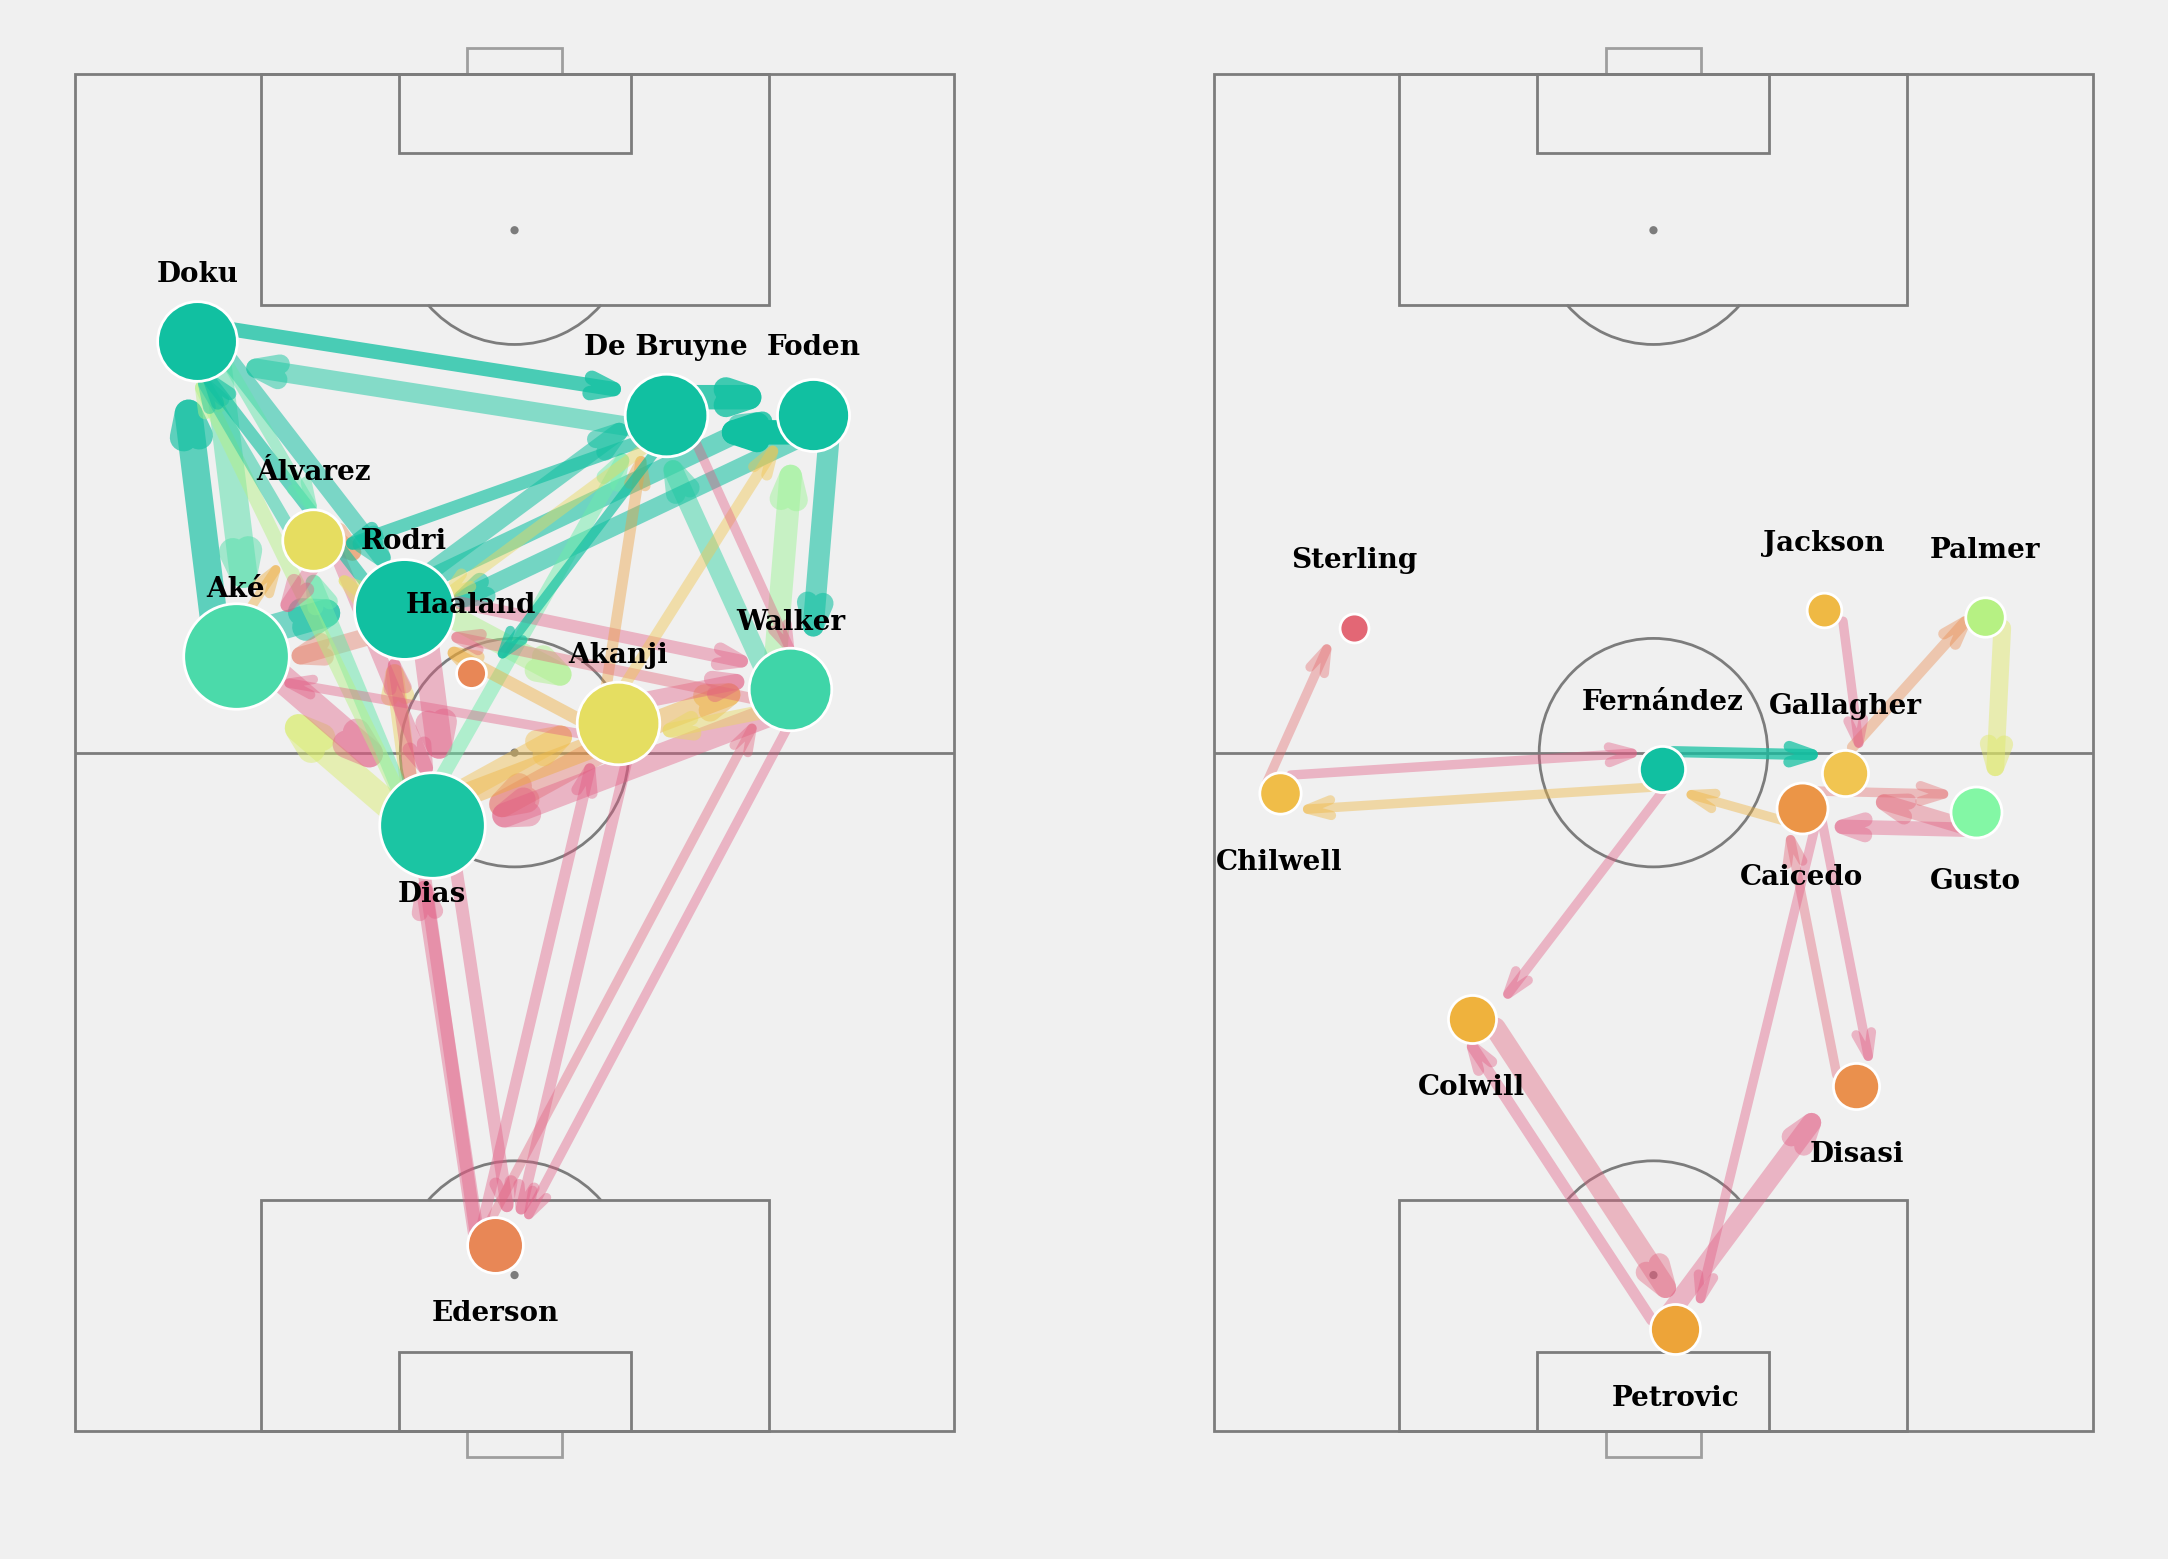

In [20]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(6,6), dpi=400)

teamId_home = events_df[events_df['h_a'] == 'h']['teamId'].unique()[0]
teamId_away = events_df[events_df['h_a'] == 'a']['teamId'].unique()[0]

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    player_pass_value = res_dict[teamid]['player_pass_value']
    pair_pass_value = res_dict[teamid]['pair_pass_value']
    minutes_ = res_dict[teamid]['minutes']

    pitch = VerticalPitch(pitch_type='opta', 
                          line_color='#7c7c7c',
                          goal_type='box',
                          linewidth=0.5,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    # Step 1: processing for plotting edges
    pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
    pair_stats = pair_stats.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= 5]
    
    # Step 2: processing for plotting nodes
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    
    #FILTER first 11 players
    mask = events_df['minute'] < minutes_
    players_ = list(set(events_df[mask]['playerName'].dropna()))
    
    mask_ = player_stats.index.map(lambda x: x in players_)
    player_stats = player_stats.loc[mask_]
    
    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]
    
    
    # Step 3: plotting nodes
    for var, row in player_stats.iterrows():
        player_x = position.loc[var]["x"]
        player_y = position.loc[var]["y"]
        
        

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size))
        norm = Normalize(vmin=min_player_value, vmax=max_player_value)
#         node_cmap = cm.get_cmap(nodes_cmap)
        node_color = node_cmap(norm(pass_value)) 
#         print(node_color)
#         node_color = tuple([0.9 if n == 3 else i for n, i in enumerate(node_color)])

        ax[i].plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax[i].plot(player_x, player_y, '.', markersize=marker_size+2, zorder=4, color='white')

        var_ = ' '.join(var.split(' ')[1:]) if len(var.split(' ')) > 1 else var
        ax[i].annotate(var_, xy=(player_x, player_y+5 if player_y > 48 else player_y - 5), ha="center", va="center", zorder=7,
                    fontsize=5, 
#                     color=tuple([min(i*1.5, 1) if n != 3 else 1 for n, i in enumerate(node_color)]), 
                    color = 'black',
                    font = 'serif',
                    weight='heavy')

        player_stats.loc[var, 'marker_size'] = marker_size
        


    # Step 4: ploting edges  
    for pair_key, row in pair_stats2.iterrows():
        player1, player2 = pair_key.split("_")

        player1_x = position.loc[player1]["x"]
        player1_y = position.loc[player1]["y"]

        player2_x = position.loc[player2]["x"]
        player2_y = position.loc[player2]["y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        line_width = change_range(num_passes, (min_pair_count, max_pair_count), (min_edge_width, max_edge_width))
        alpha = change_range(pass_value, (min_player_value, max_player_value), (0.4, 1))

        norm = Normalize(vmin=min_pair_value, vmax=max_pair_value)
        edge_cmap = cm.get_cmap(nodes_cmap)
        edge_color = edge_cmap(norm(pass_value))

        x = player1_x
        y = player1_y
        dx = player2_x-player1_x
        dy = player2_y-player1_y
        rel = 68/105
        shift_x = 2
        shift_y = shift_x*rel

        slope = round(abs((player2_y - player1_y)*105/100 / (player2_x - player1_x)*68/100),1)

        mutation_scale = 1
        if (slope > 0.5):
            if dy > 0:
                ax[i].annotate("", xy=(x+dx+shift_x, y+dy), xytext=(x+shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
                
            elif dy <= 0:
                ax[i].annotate("", xy=(x+dx-shift_x, y+dy), xytext=(x-shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
        elif (slope <= 0.5) & (slope >=0):
            if dx > 0:
#                 print(2)

                ax[i].annotate( "", xy=(x+dx, y+dy-shift_y), xytext=(x, y-shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))

            elif dx <= 0:

                ax[i].annotate("", xy=(x+dx, y+dy+shift_y), xytext=(x, y+shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
        else:
            print(1)
                
# fig.savefig('./img/pass_map.jpeg', bbox_inches='tight', dpi=400)

### 3.4 Adding legends and detail

In [21]:
def add_details(ax_n):
    
    ax[i].plot([21, 21], [ax[i].get_ylim()[0]+19, ax[i].get_ylim()[1]-19], ls=':',dashes=(1, 3), color='gray', lw=0.4)
    ax[i].plot([78.8, 78.8], [ax[i].get_ylim()[0]+19, ax[i].get_ylim()[1]-19], ls=':',dashes=(1, 3), color='gray', lw=0.4)
    ax[i].plot([36.8, 36.8], [ax[i].get_ylim()[0]+8.5, ax[i].get_ylim()[1]-8.5], ls=':',dashes=(1, 3), color='gray', lw=0.4)
    ax[i].plot([100-36.8, 100-36.8], [ax[i].get_ylim()[0]+8.5, ax[i].get_ylim()[1]-8.5], ls=':',dashes=(1, 3), color='gray', lw=0.4)

    ax[i].plot([ax[i].get_xlim()[0]-4, ax[i].get_xlim()[1]+4], [83,83], ls=':',dashes=(1, 3), color='gray', lw=0.4)
    ax[i].plot([ax[i].get_xlim()[0]-4, ax[i].get_xlim()[1]+4], [67, 67], ls=':',dashes=(1, 3), color='gray', lw=0.4)

    ax[i].plot([ax[i].get_xlim()[0]-4, ax[i].get_xlim()[1]+4], [100-83,100-83], ls=':',dashes=(1, 3), color='gray', lw=0.4)
    ax[i].plot([ax[i].get_xlim()[0]-4, ax[i].get_xlim()[1]+4], [100-67, 100-67], ls=':',dashes=(1, 3), color='gray', lw=0.4)


    head_length = 0.3
    head_width = 0.05
    ax[i].annotate(xy=(102, 58), 
                       xytext=(102, 43),zorder=2,
                       text='',
                       ha='center',
                       arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                       color='#7c7c7c',
                       lw=0.5))
    ax[i].annotate(xy=(104, 48),zorder=2,
                   text='Attack',
                   ha='center',
                   color='#7c7c7c',
                   rotation=90,
                   size=5)

    ax[i].annotate(xy=(50, -5),zorder=2,
               text=f'Passes from minutes 1 to {minutes_}',
               ha='center',
               color='#7c7c7c',
               size=6)

    font = 'serif'
    fig_text(
        x = 0.5, y = .90, 
        s = "Passing network for Man City 1 - 1 Chelsea",
        weight = 'bold',
        va = "bottom", ha = "center",
        fontsize = 10, font=font    )

    fig_text(
        x = 0.25, y = .855, 
        s = "Man City",
        weight = 'bold',
        va = "bottom", ha = "center",
        fontsize = 8, font=font    )
    fig_text(
        x = 0.73, y = .855, 
        s = "Chelsea",
        weight = 'bold',
        va = "bottom", ha = "center",
        fontsize = 8, font=font    )

    fig_text(
        x = 0.5, y = 0.875, 
        s = "Premier League | Season 2023-2024 | 2024-02-17 ",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.87, y = -0.0, 
        s = "FOOTSCI",
        va = "bottom", ha = "center", weight='bold',
        fontsize = 12, font=font, color='black')


    fig_text(
        x = 0.14, y = .14, 
        s = "Pass count between",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.38, y = .14, 
        s = "Pass value between (OP xT)",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.61, y = .14, 
        s = "Player pass count",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.84, y = .14, 
        s = "Player pass value (OP xT)",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.41, y = .038, 
        s = "Low",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.6, y = .038, 
        s = "High",
        va = "bottom", ha = "center",
        fontsize = 6, font=font)

    fig_text(
        x = 0.1, y = -0.0, 
        s = "t.me/footsci\nt.me/footsci_eng",
        va = "bottom", ha = "center", weight='bold',
        fontsize = 6, font=font, color='black')


    fig_text(
        x = 0.13, y = 0.07, 
        s = "5 to 16+",
        va = "bottom", ha = "center",
        fontsize = 5, font=font, color='black')

    fig_text(
        x = 0.37, y = 0.07, 
        s = "0 to 0.09+",
        va = "bottom", ha = "center",
        fontsize = 5, font=font, color='black')

    fig_text(
        x = 0.61, y = 0.07, 
        s = "1 to 88+",
        va = "bottom", ha = "center",
        fontsize = 5, font=font, color='black')

    fig_text(
        x = 0.84, y = 0.07, 
        s = "0.01 to 0.36+",
        va = "bottom", ha = "center",
        fontsize = 5, font=font, color='black')


    head_length = 20
    head_width = 20

    x0 = 190
    y0 = 280
    dx = 60
    dy = 120
    shift_x = 70

    x1 = 700
    x2 = 1350
    y2 = 340
    shift_x2 = 70
    radius = 20

    x3 = 1800
    shift_x3 = 100

    color='black'

    style = ArrowStyle('->', head_length=5, head_width=3)

    arrow1 = FancyArrowPatch((x0,y0), (x0+dx, y0+dy), lw=0.5,
                             arrowstyle=style, color=color) 
    arrow2 = FancyArrowPatch((x0+shift_x,y0), (x0+dx+shift_x, y0+dy), lw=1.5,
                             arrowstyle=style, color=color)
    arrow3 = FancyArrowPatch((x0+2*shift_x,y0), (x0+dx+2*shift_x, y0+dy), lw=2.5,
                             arrowstyle=style, color=color)


    arrow4 = FancyArrowPatch((x1,y0), (x1+dx, y0+dy), lw=2.5,
                             arrowstyle=style, color=node_color1) 
    arrow5 = FancyArrowPatch((x1+shift_x,y0), (x1+dx+shift_x, y0+dy), lw=2.5,
                             arrowstyle=style, color=node_color2)
    arrow6 = FancyArrowPatch((x1+2*shift_x,y0), (x1+dx+2*shift_x, y0+dy), lw=2.5,
                             arrowstyle=style, color=node_color3)
    arrow7 = FancyArrowPatch((x1+3*shift_x,y0), (x1+dx+3*shift_x, y0+dy), lw=2.5,
                             arrowstyle=style, color=node_color4)
    arrow8 = FancyArrowPatch((x1+4*shift_x,y0), (x1+dx+4*shift_x, y0+dy), lw=2.5,
                             arrowstyle=style, color=node_color5)

    # arrow1 = FancyArrow(x0,y0,dx,dy, lw=0.5, color=color,head_width=head_width, head_length=head_length)
    # arrow2 = FancyArrow(x0+shift_x,y0,dx,dy, lw=1, color=color,head_width=head_width, head_length=head_length)
    # arrow3 = FancyArrow(x0+shift_x*2,y0,dx,dy, lw=2, color=color,head_width=head_width, head_length=head_length)

    circle1 = Circle(xy=(x2, y2), radius=radius, edgecolor='black',fill=False)
    circle2 = Circle(xy=(x2+shift_x2, y2), radius=radius*1.5, edgecolor='black',fill=False)
    circle3 = Circle(xy=(x2+2.3*shift_x2, y2), radius=radius*2, edgecolor='black',fill=False)

    circle4 = Circle(xy=(x3, y2), radius=radius*2, color=node_color1)
    circle5 = Circle(xy=(x3 + shift_x3, y2), radius=radius*2, color=node_color2)
    circle6 = Circle(xy=(x3 + 2*shift_x3, y2), radius=radius*2, color=node_color3)
    circle7 = Circle(xy=(x3 + 3*shift_x3, y2), radius=radius*2, color=node_color4)
    circle8 = Circle(xy=(x3 + 4*shift_x3, y2), radius=radius*2, color=node_color5)



    fig.patches.extend([arrow1, arrow2, arrow3 ])
    fig.patches.extend([arrow4, arrow5, arrow6, arrow7, arrow8 ])
    fig.patches.extend([circle1 , circle2, circle3])
    fig.patches.extend([circle4,circle5,circle6,circle7,circle8])


    x4 = 1020
    y4 = 180
    dx = 350

    arrow9 = FancyArrowPatch((x4,y4), (x4+dx, y4), lw=1,
                             arrowstyle=style, color='black')
    
    fig.patches.extend([arrow9])


    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0, bottom = 0.1)

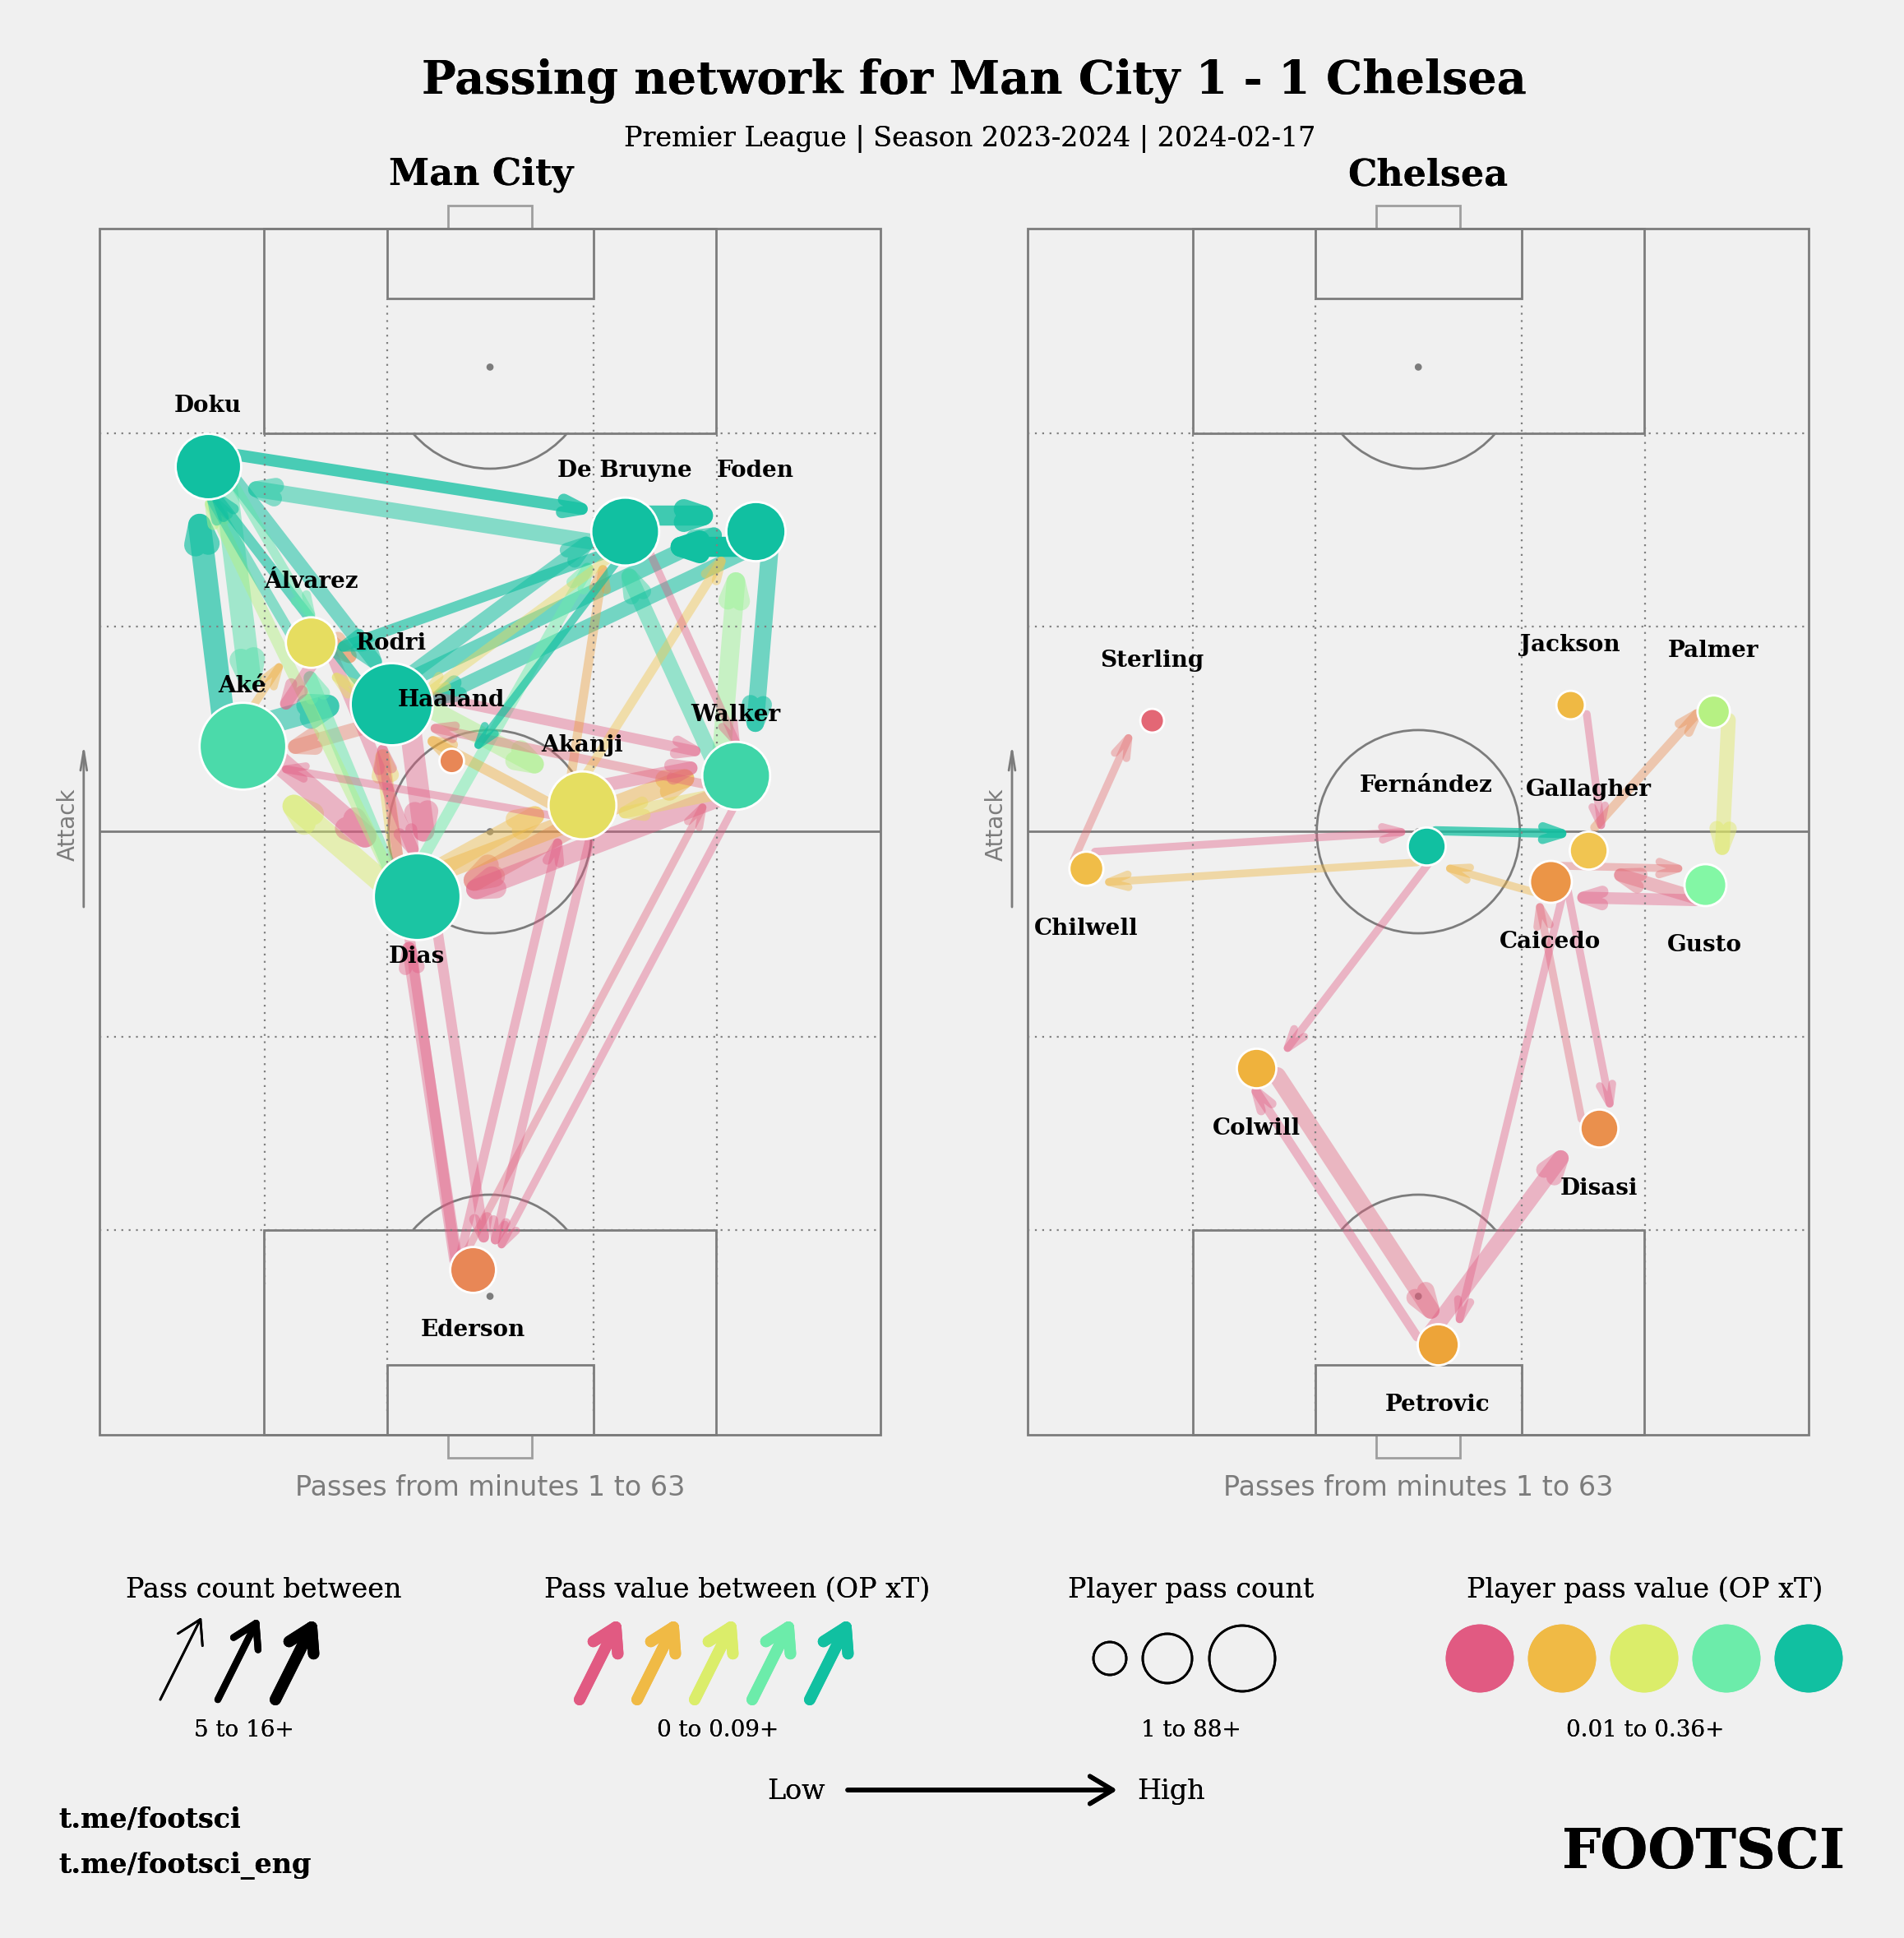

In [22]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(6,6), dpi=400)

teamId_home = events_df[events_df['h_a'] == 'h']['teamId'].unique()[0]
teamId_away = events_df[events_df['h_a'] == 'a']['teamId'].unique()[0]

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    player_pass_value = res_dict[teamid]['player_pass_value']
    pair_pass_value = res_dict[teamid]['pair_pass_value']
    minutes_ = res_dict[teamid]['minutes']

    pitch = VerticalPitch(pitch_type='opta', 
                          line_color='#7c7c7c',
                          goal_type='box',
                          linewidth=0.5,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    # Step 1: processing for plotting edges
    pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
    pair_stats = pair_stats.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]
    
    # Step 2: processing for plotting nodes
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    
    #FILTER first 11 players
    mask = events_df['minute'] < minutes_
    players_ = list(set(events_df[mask]['playerName'].dropna()))
    
    mask_ = player_stats.index.map(lambda x: x in players_)
    player_stats = player_stats.loc[mask_]
    
    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]
    
    
    # Step 3: plotting nodes
    for var, row in player_stats.iterrows():
        player_x = position.loc[var]["x"]
        player_y = position.loc[var]["y"]
        
        

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size))
        norm = Normalize(vmin=min_player_value, vmax=max_player_value)
#         node_cmap = cm.get_cmap(nodes_cmap)
        node_color = node_cmap(norm(pass_value)) 
#         print(node_color)
#         node_color = tuple([0.9 if n == 3 else i for n, i in enumerate(node_color)])

        ax[i].plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax[i].plot(player_x, player_y, '.', markersize=marker_size+2, zorder=4, color='white')

        var_ = ' '.join(var.split(' ')[1:]) if len(var.split(' ')) > 1 else var
        ax[i].annotate(var_, xy=(player_x, player_y+5 if player_y > 48 else player_y - 5), ha="center", va="center", zorder=7,
                    fontsize=5, 
#                     color=tuple([min(i*1.5, 1) if n != 3 else 1 for n, i in enumerate(node_color)]), 
                    color = 'black',
                    font = 'serif',
                    weight='heavy')

        player_stats.loc[var, 'marker_size'] = marker_size
        


    # Step 4: ploting edges  
    for pair_key, row in pair_stats2.iterrows():
        player1, player2 = pair_key.split("_")

        player1_x = position.loc[player1]["x"]
        player1_y = position.loc[player1]["y"]

        player2_x = position.loc[player2]["x"]
        player2_y = position.loc[player2]["y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        line_width = change_range(num_passes, (min_pair_count, max_pair_count), (min_edge_width, max_edge_width))
        alpha = change_range(pass_value, (min_player_value, max_player_value), (0.4, 1))

        norm = Normalize(vmin=min_pair_value, vmax=max_pair_value)
        edge_cmap = cm.get_cmap(nodes_cmap)
        edge_color = edge_cmap(norm(pass_value))

        x = player1_x
        y = player1_y
        dx = player2_x-player1_x
        dy = player2_y-player1_y
        rel = 68/105
        shift_x = 2
        shift_y = shift_x*rel

        slope = round(abs((player2_y - player1_y)*105/100 / (player2_x - player1_x)*68/100),1)

        mutation_scale = 1
        if (slope > 0.5):
            if dy > 0:
                ax[i].annotate("", xy=(x+dx+shift_x, y+dy), xytext=(x+shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
                
            elif dy <= 0:
                ax[i].annotate("", xy=(x+dx-shift_x, y+dy), xytext=(x-shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
        elif (slope <= 0.5) & (slope >=0):
            if dx > 0:
#                 print(2)

                ax[i].annotate( "", xy=(x+dx, y+dy-shift_y), xytext=(x, y-shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))

            elif dx <= 0:

                ax[i].annotate("", xy=(x+dx, y+dy+shift_y), xytext=(x, y+shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
                                        color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
                                        fc = 'blue',
                                        lw=line_width,
                                        shrinkB=player_stats.loc[player2, 'marker_size']/5))
        else:
            print(1)
            
    add_details(i)
    
fig.savefig('./img/pass_map.jpeg', bbox_inches='tight', dpi=400)